# **Ex5-3**: Object detection (Practice)

## (Optional) Prepare PASCAL VOC2007 dataset.

In [1]:
## Ex5-1 또든 Ex5-2를 통해 PASCAL VOC2007 dataset을 다운로드 받았다면, 다시 다운로드 받지 않아도 됩니다.
## link: https://drive.google.com/file/d/1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT/view?usp=sharing
## id: 1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT
## filename: VOC2007.zip
## wget error 시, PLMS 에서 직접 다운로드 후 업로드 부탁드립니다: VOC2007.zip 을 업로드 한 뒤 !unzip VOC2007.zip 실행.

# 다운로드를 위해서는 아래 명령문들을 주석 해제 해주세요.
# !apt-get update -y
# !apt-get install wget unzip -y
# !wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FSPPvm6-QZ43pCYzPA3-pyN7RZ0rq5DT" -O VOC2007.zip && rm -rf ~/cookies.txt
# !unzip VOC2007.zip
# !rm VOC2007.zip

## 1. Import packages.

In [2]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import os
import random
import math
import numpy as np
from collections import OrderedDict
import xml.etree.ElementTree as ET

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision.ops import misc as misc_nn_ops
from torchsummary import summary
!pip install pycocotools

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

### Funtion for visualization
def draw_bb(img, boxes, color='r', figsize=(8,8)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()
    
### Fuction for vislualize boudning with two differnt colors
def draw_bb2(img, boxes1, boxes2, color1='r', color2='g', figsize=(20,20)):
    fig,ax = plt.subplots(1, figsize=figsize)
    for box in boxes1:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color1,facecolor='none')
        ax.add_patch(rect)
    for box in boxes2:
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=3,edgecolor=color2,facecolor='none')
        ax.add_patch(rect)
    ax.imshow(img)
    plt.show()

## 2. Define Pascal VOC dataloader.

- Pascal VOC dataset folder structure

data/VOC2007/  

>ImageSets/Main/  
>>train.txt  
>>train_small.txt(optional)  

>JPEGImages/  
>>000005.jpg  
>>000007.jpg  
>>000009.jpg  
>>000012.jpg  
>>...  

>Annotations/  
>>000005.xml  
>>000007.xml  
>>000009.xml  
>>000012.xml  
>>...  

- PASCAL VOC image example : 

![PASCAL VOC SAMPLE IMAGE](./VOC2007/JPEGImages/000010.jpg)

### xml file example
- open any xml file by web browsers

- output of "__getitems__" should be

>image : a PIL Image of size (H, W)  
>target : a dict containing the following key  
>>boxes (FloatTensor[N, 4]) :  the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H  
>>labels (Int64Tensor[N]) : the label for each bounding box  
>>image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation  
>>area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.  
>>iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation(all set zero)  

### 2-1. Recap of the dataloader we defined in Ex5-1.

In [3]:
class PascalDataset(data.Dataset):
    def __init__(self, voc_root, image_set, transforms=None):
        # In-class implementation
        self.data_root = voc_root
        self.transforms = transforms
        
        self._classes = (
            '__background__', 'aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
            'diningtable', 'dog', 'horse', 'motorbike', 'person',
            'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        )
        self._class_to_ind = dict(zip(self._classes, range(len(self._classes))))
                      
        self.img_list = []
        splits_dir = os.path.join(voc_root, 'ImageSets/Main')
        split_f = os.path.join(splits_dir, image_set.rstrip('\n') + '.txt')
        # 'voc_root/ImageSets/Main/train.txt'
        self._load_img_name_list(split_f)
        
    def _load_img_name_list(self, img_list_path):
        with open(img_list_path, 'r') as f:
            self.img_list = f.read().splitlines()
            
    def _load_annotation(self, index, img_path):
        filename = os.path.join(self.data_root, 'Annotations', img_path + '.xml')
        tree = ET.parse(filename)
        objs = tree.findall('object')
        num_objs = len(objs)
        
        boxes = np.zeros((num_objs, 4), dtype=np.float32)
        gt_classes = np.zeros((num_objs,), dtype=np.int64)
        for ix, obj in enumerate(objs):
            bbox = obj.find('bndbox')
            
            x1 = float(bbox.find('xmin').text) - 1
            y1 = float(bbox.find('ymin').text) - 1
            x2 = float(bbox.find('xmax').text) - 1
            y2 = float(bbox.find('ymax').text) - 1
            
            class_id = self._class_to_ind[obj.find('name').text.lower().strip()]
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = class_id
            
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {}
        target["boxes"] = boxes
        target["labels"] = torch.as_tensor(gt_classes, dtype=torch.int64)
        target["image_id"] = torch.tensor([index])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)
        
        return target
        
    def __len__(self,):
        # In-class implementation
        return len(self.img_list)

    def __getitem__(self, index):
        # In-class implementation
        img_path = self.img_list[index]
        img = Image.open(os.path.join(
            self.data_root, 'JPEGImages', img_path + '.jpg')).convert('RGB')
        target = self._load_annotation(index, img_path)
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target

### 2-2. Visualize a sample.

torch.Size([3, 333, 500]) 
 {'boxes': tensor([[155.,  96., 350., 269.]]), 'labels': tensor([7]), 'image_id': tensor([0]), 'area': tensor([33735.]), 'iscrowd': tensor([0])}


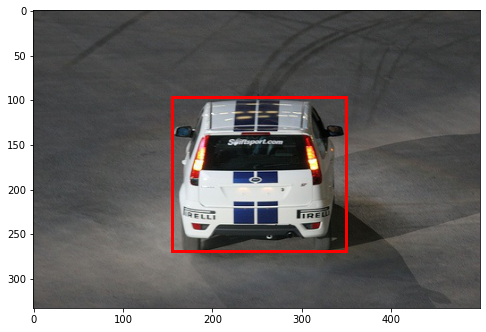

In [4]:
import torchvision.transforms as T

transfroms = T.Compose([
    T.PILToTensor()
])

voc_data = PascalDataset(voc_root='./VOC2007/', image_set='train', transforms=transfroms)
voc_iter = iter(voc_data)
img, label = next(voc_iter)

print(img.shape, '\n', label)

img_PIL = T.ToPILImage()(img.clone())
bb_label = label['boxes']
draw_bb(img=img_PIL, boxes=bb_label)

## 3. Define Faster-RCNN.

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# doc: https://pytorch.org/vision/stable/_modules/torchvision/models/detection/faster_rcnn.html

# load a model pre-trained pre-trained on COCO train 2017, COCO는 class 91개
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 21  #  class (20) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequen

## 4. Fine-tune Faster-RCNN.

In [9]:
#from engine import train_one_epoch, evaluate
import torch
import torchvision.transforms as T

transfroms = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalization value
])

# train on the GPU or on the CPU, if a GPU is not available
voc_train = PascalDataset(
    voc_root='./VOC2007/', image_set='train', transforms=transfroms
)
voc_test = PascalDataset(
    voc_root='./VOC2007/', image_set='val', transforms=transfroms
)
batch_size = 16

def collate_fn(batch):
    zip_batch = zip(*batch)
    tuple_batch = tuple(zip_batch)
    return tuple_batch

### define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    voc_train, batch_size=16, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    voc_test, batch_size=16, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

# move model to device
model = model.to(device)

# construct an optimizer
# params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

In [ ]:
# let's train it for 1 epochs
num_epochs = 10
# print loss every 10 mini-batches
print_step = 10

# train for one epoch, printing every 10 iterations
for epoch in range(num_epochs):
    ## enumerate through data_loader
    ### Train mode
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader_train):
        
        ### Load input data
        images = list(image.to(device) for image in images)        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        ### Forward & loss aggregation
        loss_dict = model(images, targets)
        
#         로스 종류 확인
#         print(loss_dict.keys())
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
    
        ### BackPropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        ### print itermedicate outputs
        if(batch_idx % print_step == 0):
            print('Epoch: [{}/{}], Iterations: [{}/{}], loss: {}  '.format(epoch, num_epochs, batch_idx, len(data_loader_train), loss_value))

print('Training Done!')

In [10]:
# predefined evaluation function
from engine import evaluate
#egg=pycocotools^&subdirectory=PythonAPI.
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [  0/157]  eta: 0:09:32  model_time: 2.7288 (2.7288)  evaluator_time: 0.1011 (0.1011)  time: 3.6463  data: 0.6216  max mem: 0


KeyboardInterrupt: 

## 5. Visulize the evaluation results.

In [ ]:
# eval mode
model.eval();

In [ ]:
data_it = iter(data_loader_test)

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

In [ ]:
imgs, labels = next(data_it)

img_test = imgs[0]
bbox_test = labels[0]['boxes']

prediction = model(list([img_test.to(device)]))
scores = prediction[0]['scores']
print(scores)
threshold = (scores>0.8).sum().cpu().detach().item()
print(threshold)
### transform for visulization
P = torchvision.transforms.ToPILImage()
img_test_PIL = P(img_test)
prediction_bbox_np = prediction[0]['boxes'].cpu().detach().numpy()[:threshold]
draw_bb2(img_test_PIL, bbox_test, prediction_bbox_np)
print(prediction[0]['labels'])

## (Optional) Test on an image you want.

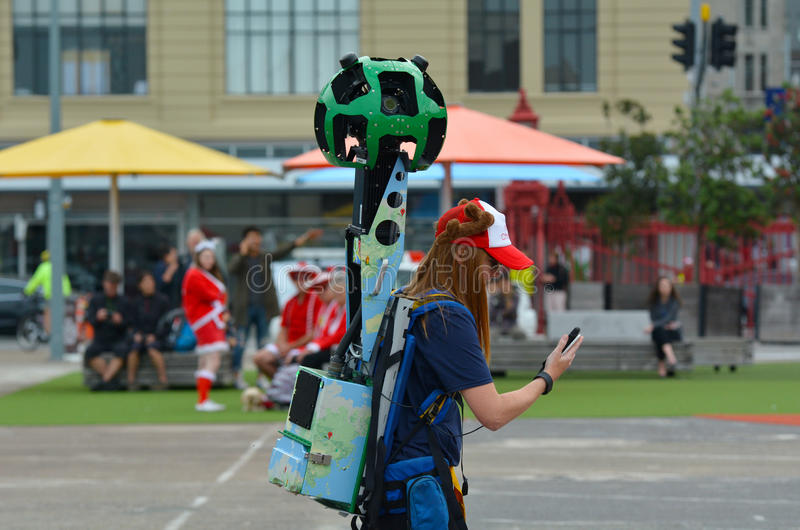

In [11]:
# read image
img_demo = Image.open('./sample.jpg').convert("RGB")
img_demo 

'__background__' - 0,
'aeroplane' - 1,
'bicycle' - 2,
'bird' - 3,
'boat'- 4,
'bottle'- 5,
'bus'- 6,
'car'- 7,
'cat'- 8,
'chair'- 9,
'cow'- 10,
'diningtable' - 11,
'dog' - 12,
'horse' - 13,
'motorbike' - 14,
'person' - 15,
'pottedplant' - 16,
'sheep' - 17,
'sofa'- 18,
'train' - 19,
'tvmonitor' - 20

tensor([0.9753, 0.9598], device='cuda:1', grad_fn=<SliceBackward0>)
tensor([1, 1], device='cuda:1')
[[384.10648 203.37805 575.6567  519.8382 ]
 [647.4691  278.7979  691.75006 377.65164]]


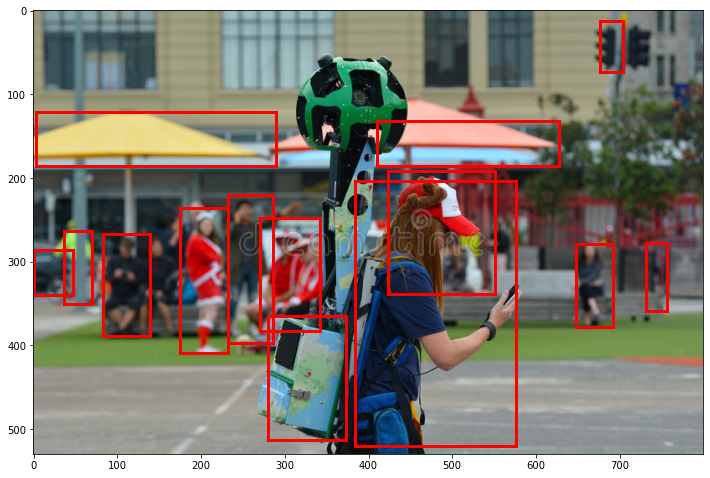

In [21]:
# Forward through trained model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
    pretrained=True)
model = model.to(device)
model.eval()

bboxes_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['boxes']
scores_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['scores']
labels_demo = model([torchvision.transforms.ToTensor()(img_demo).to(device)])[0]['labels']
bboxes_demo_np = bboxes_demo.cpu().detach().numpy()

threshold = (scores_demo>0.9).sum().cpu().detach().item()
mask = (scores_demo > 0.3).cpu().detach().numpy()
bboxes_demo_np_thrs = bboxes_demo_np[mask]

print(scores_demo[:threshold])
print(labels_demo[:threshold])
print(bboxes_demo_np[:threshold])

# Draw bounding boxes
draw_bb(img_demo, bboxes_demo_np_thrs, 'r', (12, 12))